In [29]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm

## The Equation

Consider the following equation:

$$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \bigg(\kappa \frac{\partial T}{\partial z}\bigg) + \bigg(\frac{Q(t)}{\rho_0 c_p z_m} - \gamma\big(T - (T_i(z) + T_0)\big) \bigg) \times H(z_m - z) - \mu \big(T - T_i(z) \big) \times H(z - z_d) + \text{C.A.},$$ 

where $T = T(t, z)$ is the temperature (MAKE A NOTE OF WHETHER WE THINK OF THIS AS POTENTIAL, CONSERVATIVE, IN SITU, ETC.); $\kappa$ is the (constant) diffusivity; $Q(t)$ is a prescribed, time-dependent surface heat flux; $\rho_0 = 1025$ kg m$^{-3}$ is the reference density; $c_p = 4000$ J/(kg C) is the specific heat capacity; $z_m$ is the depth of the mix*ing* layer (i.e., a minimum mixed layer); $\gamma$ is a damping term (acting like a climate feedback parameter) which acts to restore the surface back to some initial state $T_i(z)$. The term $T_0$ is applied in perturbations to perturb the surface temperature (like an air temperature perturbation). The $H$ represents a Heaviside function to denote that this forcing and restoring is applied over the minimum mixing layer. The next term is a deep ocean restoring term which acts to balance the surface restoring at the surface. This is so that the steady-state solution is not simply a profile of constant temperature equal to the surface temperature. The paramater $\mu$ is a characteristic timescale over which the temperature profile is relaxed back to its initial profile $T_i(z)$ in the deep ocean (e.g., 20 years), applied only below some prescribed depth $z_d$ (e.g., $z_d = 900$m).

Finally, the term 'C.A.' denotes a convective adjustment algorithm, following _Rahmstorf (1993)_, which checks at each timestep whether any convective instabilities arise and removes them conservatively.

We will write a forward-time, central-space finite difference scheme for this equation. I have also solved analytically for the steady-state solution, which can be found in an Appendeix to the thesis.

In [105]:
# Constants, data, parameters...

rho = 1025 # kg/m^3
c = 4000 # J/(kg C)

z_m = 50.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

mu = 1/(20 * 365 * 86400) # Deep ocean restoring time scale
gamma = 1/(1.5 * 365 * 86400) # Surface restoring time scale (to be determined through my least squares regression)
kappa = 7e-6

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

In [106]:
# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz/2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)

In [107]:
# Analytical steady state, cf. Appendix 1

def steady_state(Z):
    
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # Coefficients
    a_1 = (A * E + B * F) / (A * D - C * F)
    
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # Piecewise defined function (ie, need to use vectorise):
    if Z <= z_m:
        
        return T_0 + a_1 * (np.exp(Z * np.sqrt(gamma / kappa)) + np.exp( - Z * np.sqrt(gamma / kappa)))
    
    elif Z > z_m and Z < z_d:
        
        return T_0 + a_1 * (np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (Z - z_m) \
                            + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    else:
        
        return ((T_0 - T_b) * Z + z_m * T_b - z_b * T_0) / (z_m - z_b) \
    + c_1 * (1 + np.exp(2 * (z_b - Z) * np.sqrt(mu / kappa))) * np.exp(Z * np.sqrt(mu / kappa)) \
    + np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b) * np.exp((z_b - Z) * np.sqrt(mu / kappa))
    
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)

In [108]:
### Intermediate functions

def convective_adjustment(T):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz)):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
        #OHC[i] = rho * c * np.cumsum(T[: , i])[- 1] * dz # This is for ocean heat content
        
        OHC[i] = np.mean(T[:, i]) # This is for average temperature
        
    return OHC    

In [109]:
def model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_initial, Q, T0, years):
    
    # Data
    
    radiative_forcing = Q / (c * rho * z_m)
    
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top/bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top/bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, zero elsewhere
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, zero elsewhere
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    
    T = np.zeros((M, N + 1)) # i.e. evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e. evaluated at the top/bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    #T[-1, :] = T_bot
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
        
    for n in range(0, N):
        
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M): # NB: Needs to go to M - 1 if setting the temperature at the base.
             
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T[m, 0]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T[m, 0]) * Hdeep[m] 
            # NB: "+ w" since z is positive downwards, this is an upwelling velocity, implying that it would have been negative on the LHS
            #  + w * dt * (- F[m + 1, n] / kappa) \

            
        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1])
        
    return T

In [102]:
# Trying to fix Rahmstorf...

years = 50

Q = np.ones(int(years * 360 / days) + 1) * - 2.2
T0 = np.ones(int(years * 360 / days) + 1) * - 1
kappa = 1e-6
gamma = 1/(0.5 * 365 * 86400) # Surface restoring time scale (to be determined through my least squares regression)


control_expt = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q, T0, years)

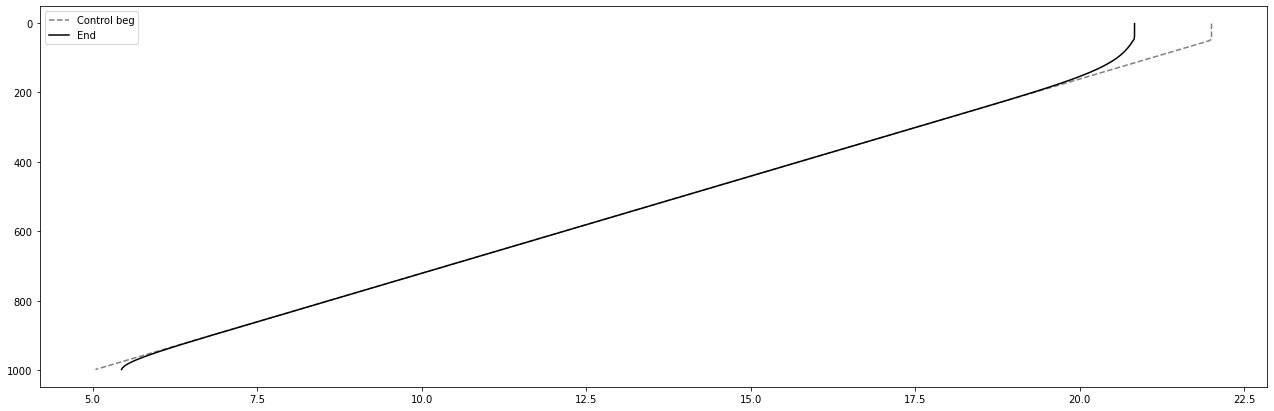

In [96]:
plt.figure(figsize=(22,7))

plt.plot(T_i, z_t, label='Control beg', color = 'gray', linestyle = '--')
plt.plot(control_expt[:, -1], z_t, label='End', color = 'k')

plt.gca().invert_yaxis()
plt.legend()

In [110]:
# Control

years = 300
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

# Control

Q = np.zeros(int(years * 360 / days) + 1)
T0 = np.zeros(int(years * 360 / days) + 1)

control_expt = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q, T0, years)

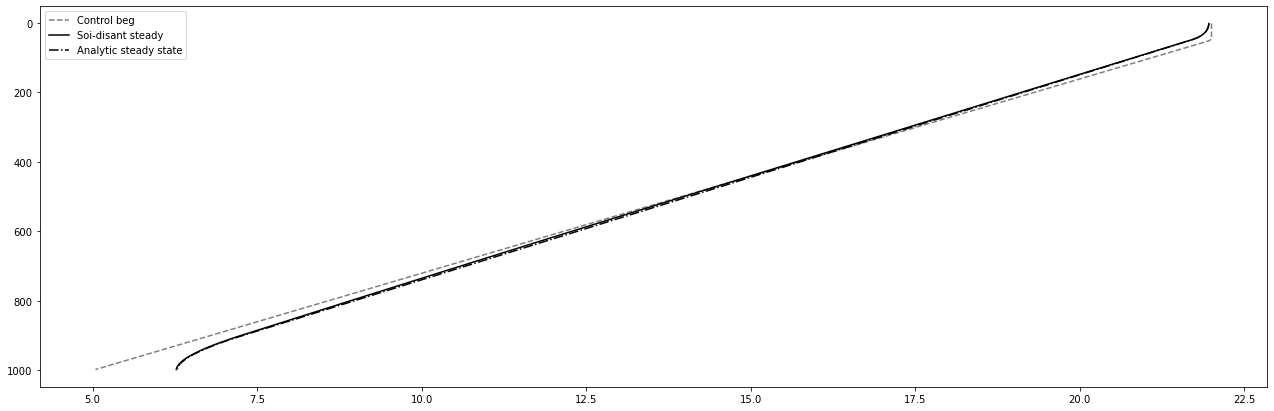

In [111]:
plt.figure(figsize=(22,7))

plt.plot(T_i, z_t, label='Control beg', color = 'gray', linestyle = '--')
plt.plot(control_expt[:,-1], z_t, label='Soi-disant steady', color = 'k')
plt.plot(steady, z_t, label='Analytic steady state', color = 'k', linestyle = '-.')

plt.gca().invert_yaxis()
plt.legend()

In [19]:
### Run experiment

years = 300
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

gamma_year = 1.3
gamma = 1/(gamma_year * 365 * 86400)
mu_year = 100
mu = 1/(mu_year * 365 * 86400)

# Control

Q = np.zeros(int(years * 360 / days) + 1)
T0 = np.zeros(int(years * 360 / days) + 1)
control = model(dt, dz, kappa, gamma, z_mix, years, steady, Q, T0)

# Constant perturbation

# Q = np.ones(int(years * 360 / days) + 1) * 2.0
# T0 = np.ones(int(years * 360 / days) + 1) * 0.7
# cool = model(dt, dz, kappa, gamma, z_mix, years, steady, - Q, - T0)
# warm = model(dt, dz, kappa, gamma, z_mix, years, steady, Q, T0)
# coolx2 = model(dt, dz, kappa, gamma, z_mix, years, steady, - 2 * Q, - 2 * T0)
# warmx2 = model(dt, dz, kappa, gamma, z_mix, years, steady, 2 * Q, 2 * T0)
# coolxhalf = model(dt, dz, kappa, gamma, z_mix, years, steady, - 0.5 * Q, - 0.5 * T0)
# warmxhalf = model(dt, dz, kappa, gamma, z_mix, years, steady, 0.5 * Q, 0.5 * T0)

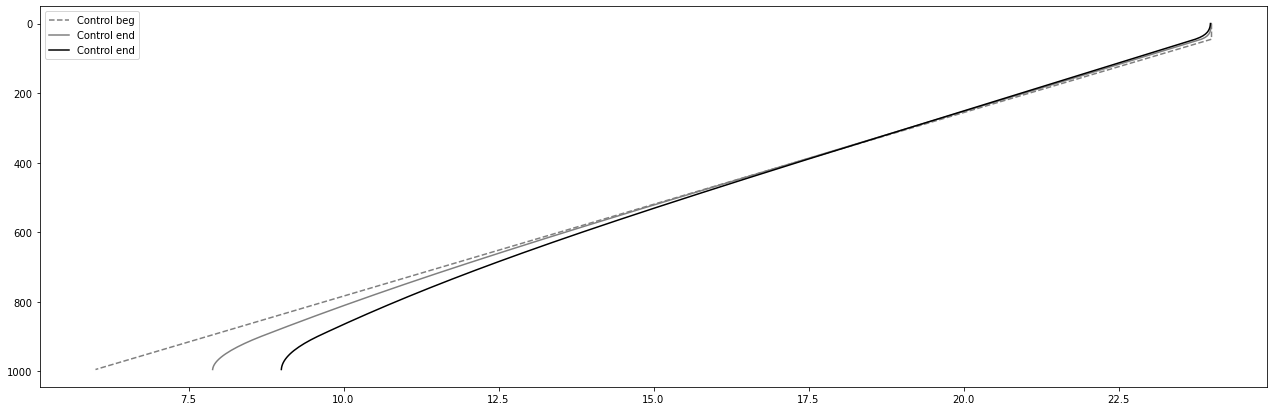

In [20]:
plt.figure(figsize=(22,7))

plt.plot(control[:,0], z[:-1], label='Control beg', color = 'gray', linestyle = '--')
plt.plot(control[:,-1], z[:-1], label='Control end', color = 'gray')
plt.plot(control1[:,-1], z[:-1], label='Control end', color = 'k')
# plt.plot(cool[:,-1], z[:-1], label='Cool', color = 'b')
# plt.plot(warm[:,-1], z[:-1], label='Warm', color = 'r')

# plt.plot(control[:,0], z[1:], label='Initial condition', color = 'gray')
# plt.plot(cool[:,-1], z[1:], label='Cool', color = 'b')
# plt.plot(coolx2[:,-1], z[1:], label='Double cool', color = 'b', linestyle = '--')
# plt.plot(coolxhalf[:,-1], z[1:], label='Half cool', color = 'b', linestyle = '-.')
# plt.plot(warm[:,-1], z[1:], label='Warm', color = 'r')
# plt.plot(warmx2[:,-1], z[1:], label='Double warm', color = 'r', linestyle = '--')
# plt.plot(warmxhalf[:,-1], z[1:], label='Half warm', color = 'r', linestyle = '-.')

plt.gca().invert_yaxis()
plt.legend()

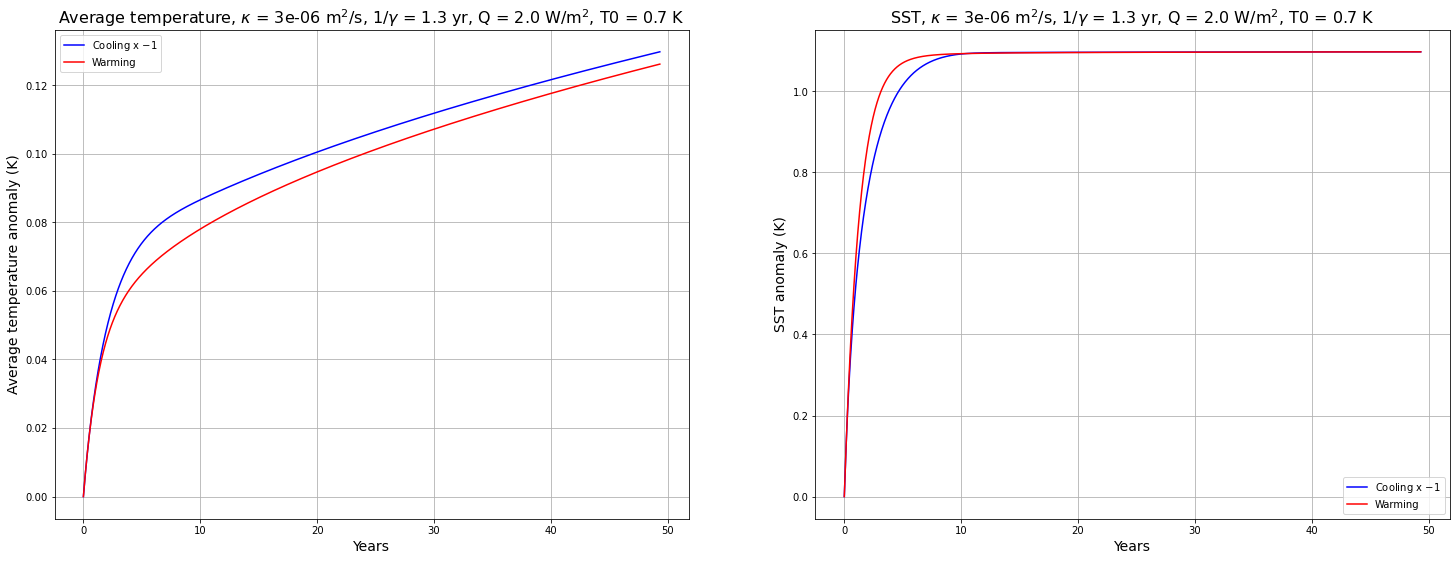

In [10]:
# Plot

days = dt / 86400
timesteps = control.shape[1]
length = (timesteps - 1) * days / 365 
time_years = np.linspace(0,length,timesteps)

#Calculate ocean heat content
GAT_control = OHC(control)
GAT_cool = OHC(cool)
GAT_warm = OHC(warm)
# GAT_coolx2 = OHC(coolx2)
# GAT_warmx2 = OHC(warmx2)
# GAT_coolxhalf = OHC(coolxhalf)
# GAT_warmxhalf = OHC(warmxhalf)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,9))

# Ocean heat content over time

axs[0].plot(time_years, - 1 * (GAT_cool - GAT_control), color='b', label='Cooling x $-1$')
#axs[0].plot(time_years, - 2 * (GAT_coolxhalf - GAT_control), color='b', label='Half cooling x $-2$', linestyle = '-.')
#axs[0].plot(time_years, - 0.5 * (GAT_coolx2 - GAT_control), color='b', label='Double cooling x $-0.5$', linestyle = '--')
axs[0].plot(time_years, GAT_warm - GAT_control, color='r', label='Warming')
#axs[0].plot(time_years, 2 * (GAT_warmxhalf - GAT_control), color='r', label='Half warming x $2$', linestyle = '-.')
#axs[0].plot(time_years, 0.5 * (GAT_warmx2 - GAT_control), color='r', label='Double warming', linestyle = '--')
#axs[0].plot(time_years, (GAT_warm - GAT_control) + (GAT_cool - GAT_control))
axs[0].grid()
axs[0].set_title('Average temperature, $\kappa$ = {} m$^2$/s, $1/\gamma$ = {} yr, Q = {} W/m$^2$, T0 = {} K'.format(kappa, gamma_year, Q[0], T0[0]), fontsize = 16)
axs[0].set_ylabel('Average temperature anomaly (K)', fontsize = 14)
axs[0].set_xlabel('Years', fontsize = 14)
axs[0].legend()

# SST over time
axs[1].plot(time_years,  - 1 * (cool[0, :] - control[0, :]), color='b', label='Cooling x $-1$')
#axs[1].plot(time_years,  - 2 * (coolxhalf[0, :] - control[0, :]), color='b', label='Half cooling x $-2$', linestyle = '-.')
#axs[1].plot(time_years,  - 0.5 * (coolx2[0, :] - control[0, :]), color='b', label='Double cooling x $-0.5$', linestyle = '--')
axs[1].plot(time_years, warm[0, :] - control[0, :], color='r',label='Warming')
#axs[1].plot(time_years,  2 * (warmxhalf[0, :] - control[0, :]), color='r', label='Double warming x $2$', linestyle = '-.')
#axs[1].plot(time_years, 0.5 * (warmx2[0, :] - control[0, :]), color='r',label='Double warming x $0.5', linestyle = '--')

#axs[1].plot(time_years, (warm_expt[0, :] - control_expt[0, :]) + (cool_expt[0, :] - control_expt[0, :]))
axs[1].grid()
axs[1].set_title('SST, $\kappa$ = {} m$^2$/s, $1/\gamma$ = {} yr, Q = {} W/m$^2$, T0 = {} K'.format(kappa, gamma_year, Q[0], T0[0]), fontsize = 16)
axs[1].set_ylabel('SST anomaly (K)', fontsize = 14)
axs[1].set_xlabel('Years',fontsize = 14)
axs[1].legend()
#plt.savefig('SST and OHC anomalies, single abrupt, kappa = {}, Q = {}, gamma = {}.jpg'.format(kappa, Q, gamma_year))

In [56]:
# #Animate the forcing

# fig = plt.figure(figsize=(18,11))
# ax = plt.axes(xlim=(4, 25), ylim=(z[0], z[-1]))

# line, = plt.plot([], [])

# def init():
#     line.set_data([], [])
#     return line,

# def animate(i):
#     line.set_data(warm_expt[:, i], z[1 : ])
#     return line,

# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=len(warm_expt[0, :]), interval=50, blit=True)

# title = 'Temperature over depth, cooling'

# ax.set_title(title, fontsize = 18)
# ax.set_xlabel('Temperature (deg C)', fontsize = 15)
# ax.set_ylabel('Depth (m)', fontsize = 15)
# ax.invert_yaxis()

# anim.save('Warming.mp4')
# #plt.show()

## Oscillatory forcing

In [111]:
def step(amp, period):
    period_day = period * 360
    return amp * np.sign(np.sin((2 * np.pi / period_day) * t))
#     return amp * np.sin((np.pi / period_day) * t)

In [112]:
# Oscilatory perturbation

# 'Run' the experiment
years = 300
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

# Control

Q = np.zeros(int(years * 360 / days) + 1)
T0 = np.zeros(int(years * 360 / days) + 1)
control_expt = model(dt, dz, kappa, gamma, z_mix, years, steady, Q, T0)

P = 4
R = 2
T0 = 0.5
cw_forcing = step(- R, P)
cw_restoring = step(- T0, P)
wc_forcing = step(R, P)
wc_restoring = step(T0, P)

cw_expt = model(dt, dz, kappa, gamma, z_mix, years, steady, cw_forcing, cw_restoring)
wc_expt = model(dt, dz, kappa, gamma, z_mix, years, steady, wc_forcing, wc_restoring)

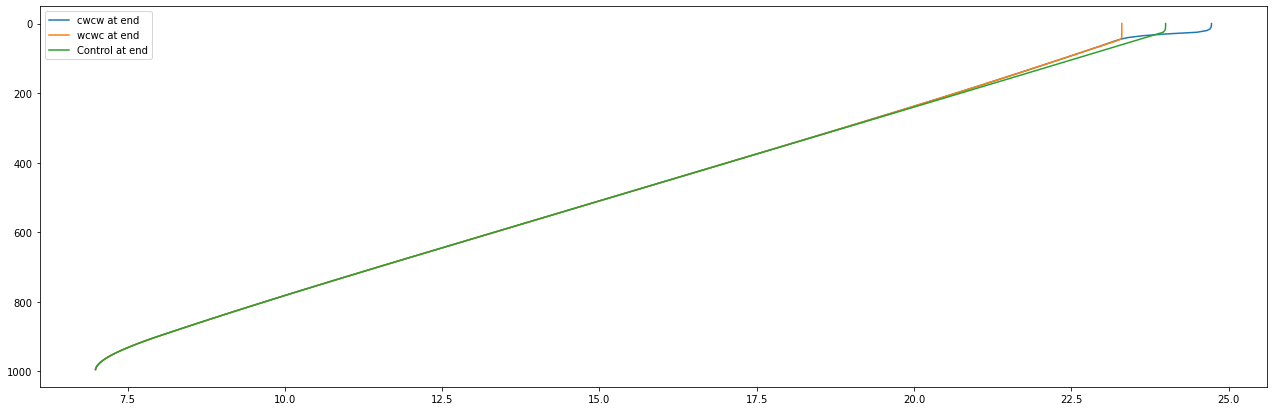

In [127]:
plt.figure(figsize=(22,7))

time_index = -1

plt.plot(cw_expt[:, time_index], z[:-1], label='cwcw at end')
plt.plot(wc_expt[:, time_index], z[:-1], label='wcwc at end')
plt.plot(control_expt[:, time_index], z[:-1], label='Control at end')

plt.gca().invert_yaxis()
plt.legend()

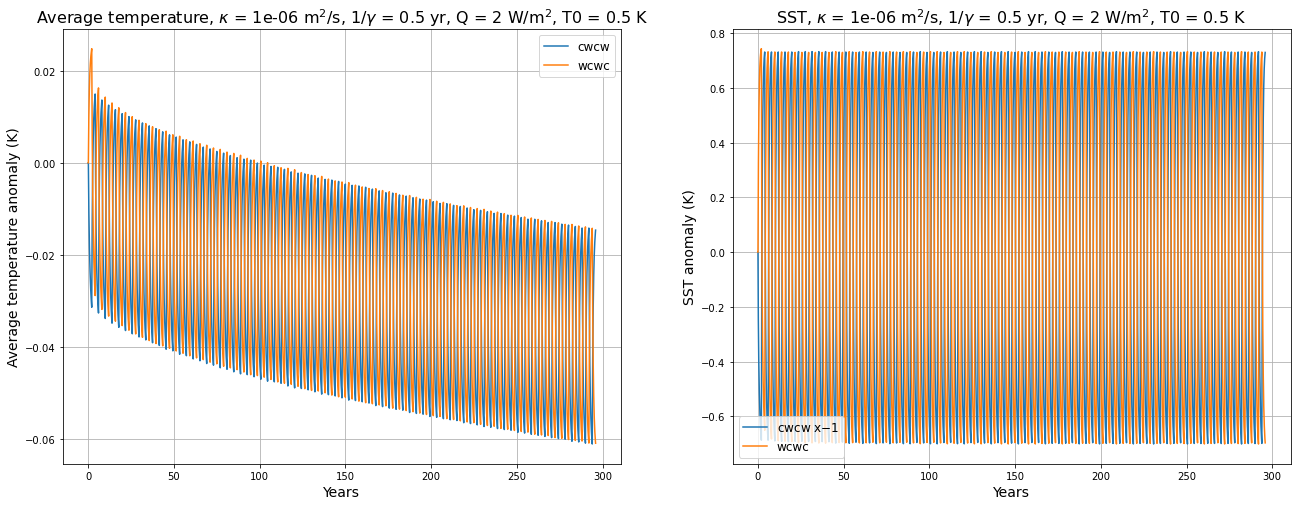

In [125]:
# Ocean heat content over time

days = dt / 86400
timesteps = cw_expt.shape[1]
length = (timesteps - 1) * days/365
time_years = np.linspace(0,length,timesteps)

#Calculate ocean heat content
OHC_control = OHC(control_expt)
OHC_cw = OHC(cw_expt)
OHC_wc = OHC(wc_expt)

#Plot
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(22,8))
axs[0].plot(time_years, 1 * (OHC_cw - OHC_control), label='cwcw')
axs[0].plot(time_years, OHC_wc - OHC_control, label='wcwc')
axs[0].grid()
axs[0].set_title('Average temperature, $\kappa$ = {} m$^2$/s, $1/\gamma$ = {} yr, Q = {} W/m$^2$, T0 = {} K'.format(kappa, gamma_year, R, T0), fontsize = 16)
axs[0].set_ylabel('Average temperature anomaly (K)', fontsize = 14)
axs[0].set_xlabel('Years', fontsize = 14)
axs[0].legend(fontsize=12, loc='upper right')

# SST over time
axs[1].plot(time_years, 1 * (cw_expt[0, :] - control_expt[0, :]), label='cwcw x$-1$')
axs[1].plot(time_years, (wc_expt[0, :] - control_expt[0, :]), label='wcwc')
axs[1].grid()
axs[1].set_title('SST, $\kappa$ = {} m$^2$/s, $1/\gamma$ = {} yr, Q = {} W/m$^2$, T0 = {} K'.format(kappa, gamma_year, R, T0), fontsize = 16)
axs[1].set_ylabel('SST anomaly (K)', fontsize = 14)
axs[1].set_xlabel('Years',fontsize = 14)
axs[1].legend(fontsize=12, loc='lower left')

#plt.savefig('SST and OHC anomalies, oscillatory, kappa = {}, Q = {}, gamma = {}.jpg'.format(kappa, Q, gamma_year))

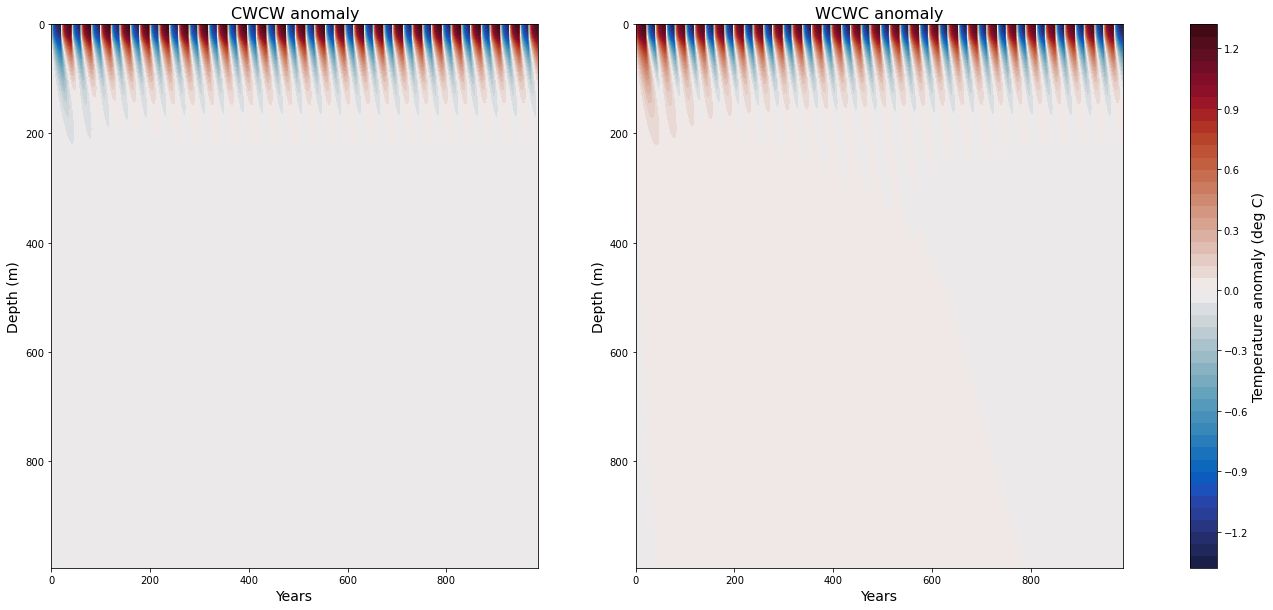

In [197]:
### Hovmoller plot

tt, zz = np.meshgrid(time_years, z[:-1])
cw_expt_anom = cw_expt - control_expt
wc_expt_anom = wc_expt - control_expt

cmap = cm.cm.balance
Tmin = np.min(cw_expt_anom)
Tmax = np.max(cw_expt_anom)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(24,10))
p1 = axs[0].contourf(tt, zz, cw_expt_anom, levels=51, cmap=cmap, norm=TwoSlopeNorm(0))
#axs[0].colorbar().set_label(label='Temperature anomaly (deg C)', size=16)
axs[0].set_title('CWCW anomaly', fontsize = 16)
axs[0].set_xlabel('Years', fontsize = 14)
axs[0].set_ylabel('Depth (m)', fontsize = 14)
axs[0].invert_yaxis()
#plt.colorbar(p1, ax=axs[0], orientation='vertical').set_label(label='Temperature anomaly (deg C)', fontsize = 14)


p2 = axs[1].contourf(tt, zz, wc_expt_anom, levels=51, cmap=cmap, norm=TwoSlopeNorm(0))
axs[1].set_title('WCWC anomaly', fontsize = 16)
axs[1].set_xlabel('Years', fontsize = 14)
axs[1].set_ylabel('Depth (m)', fontsize = 14)
axs[1].invert_yaxis()
fig.colorbar(p1, ax=axs[:], orientation='vertical').set_label(label='Temperature anomaly (deg C)', fontsize = 14)

#plt.savefig('Hovmoller, cwcw, wcwc.jpg')

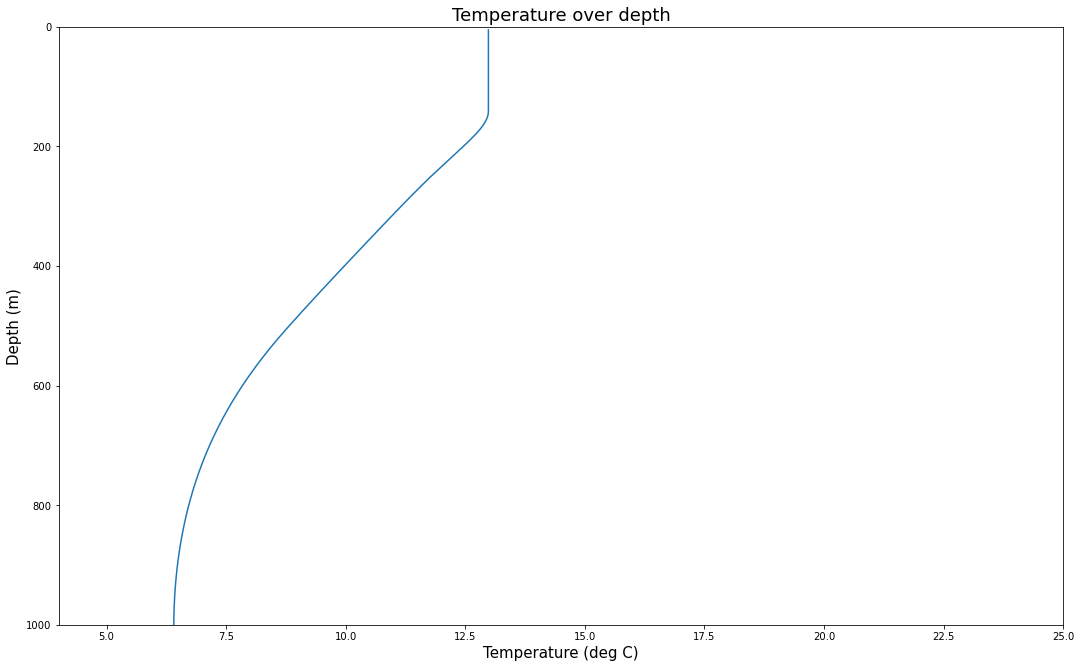

In [445]:
# #Animate the forcing

# wc_expt_animate = wc_expt[:, :3601]

# fig = plt.figure(figsize=(18,11))
# ax = plt.axes(xlim=(4, 25), ylim=(z[0], z[-1]))

# line, = plt.plot([], [])

# def init():
#     line.set_data([], [])
#     return line,

# def animate(i):
#     line.set_data(wc_expt_animate[:, i], z[1 : ])
#     return line,

# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=len(wc_expt_animate[0, :3601]), interval=50, blit=True)

# title = 'Temperature over depth'

# ax.set_title(title, fontsize = 18)
# ax.set_xlabel('Temperature (deg C)', fontsize = 15)
# ax.set_ylabel('Depth (m)', fontsize = 15)
# ax.invert_yaxis()

# #anim.save('wcwc.mp4')
# #plt.show()

## Ramp-up/ramp-down with variability

In [14]:
def ramp(t, forcing_max):
    # t is the time array
    return (forcing_max / t[ - 1]) * t # gradient = rise / run

def ramp_variable(t, forcing_max, amp, period):
    # t is the time array    
    period_day = period * 360
    return (forcing_max / t[ - 1]) * t + amp * np.sin((np.pi / period_day) * t)

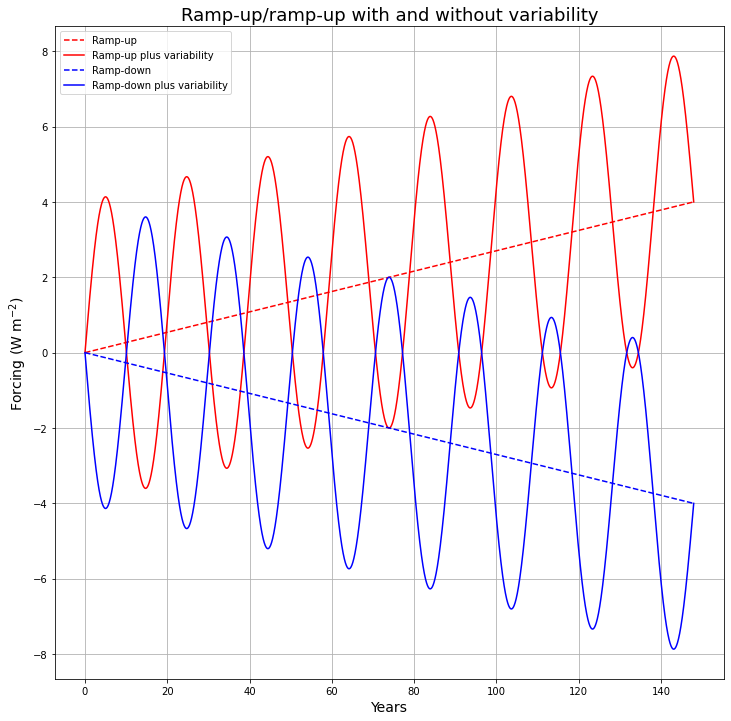

In [15]:
forcing_max = 4
variable_amp = 4
period = 10

plt.figure(figsize=(12,12))
plt.plot(time_years, ramp(t, forcing_max), color='r', linestyle='--', label='Ramp-up')
plt.plot(time_years, ramp_variable(t, forcing_max, variable_amp, period), color='r', label='Ramp-up plus variability')
plt.plot(time_years, ramp(t, -forcing_max), color='b', linestyle='--', label='Ramp-down')
plt.plot(time_years, ramp_variable(t, -forcing_max, -variable_amp, period), color='b', label='Ramp-down plus variability')
plt.title('Ramp-up/ramp-up with and without variability', fontsize=18)
plt.ylabel('Forcing (W m$^{-2}$)', fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.grid()
plt.legend()

In [16]:
# Oscilatory perturbation

# 'Run' the experiment
years = 150
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

# Control

Q = np.ones(int(years * 360 / days) + 1) * 0
gamma_year = 2
gamma = 1/(gamma_year * 365 * 86400)
mu_year = 50
mu = 1/(365 * mu_year * 86400)
T_surf = T_i[0] # Temperature relaxed back to. This is the surface temperature at the beginning of the experiment

control_expt = model(dt, dz, kappa, gamma, z_mix, years, steady, Q)[0]

forcing_max = 12
variable_amp = 4
period = 10
rampup_force = ramp(t, forcing_max)
rampup_vari_force = ramp_variable(t, forcing_max, variable_amp, period) 
rampdown_force = ramp(t, - forcing_max)
rampdown_vari_force = ramp_variable(t, -forcing_max, -variable_amp, period) 

rampup = model(dt, dz, kappa, gamma, z_mix, years, steady, rampup_force)[0]
rampup_vari = model(dt, dz, kappa, gamma, z_mix, years, steady, rampup_vari_force)[0]
rampdown = model(dt, dz, kappa, gamma, z_mix, years, steady, rampdown_force)[0]
rampdown_vari = model(dt, dz, kappa, gamma, z_mix, years, steady, rampdown_vari_force)[0]

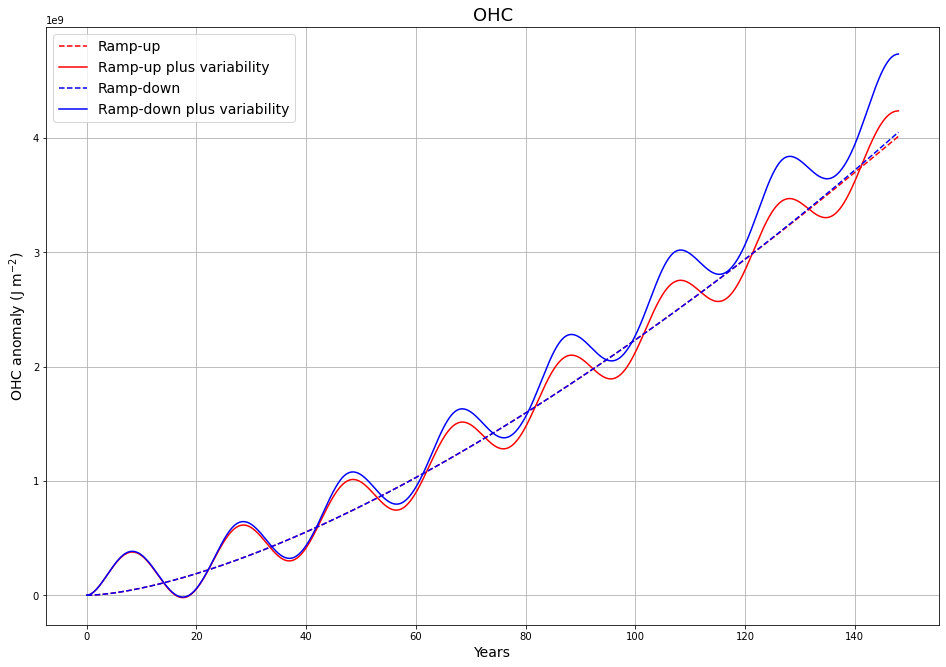

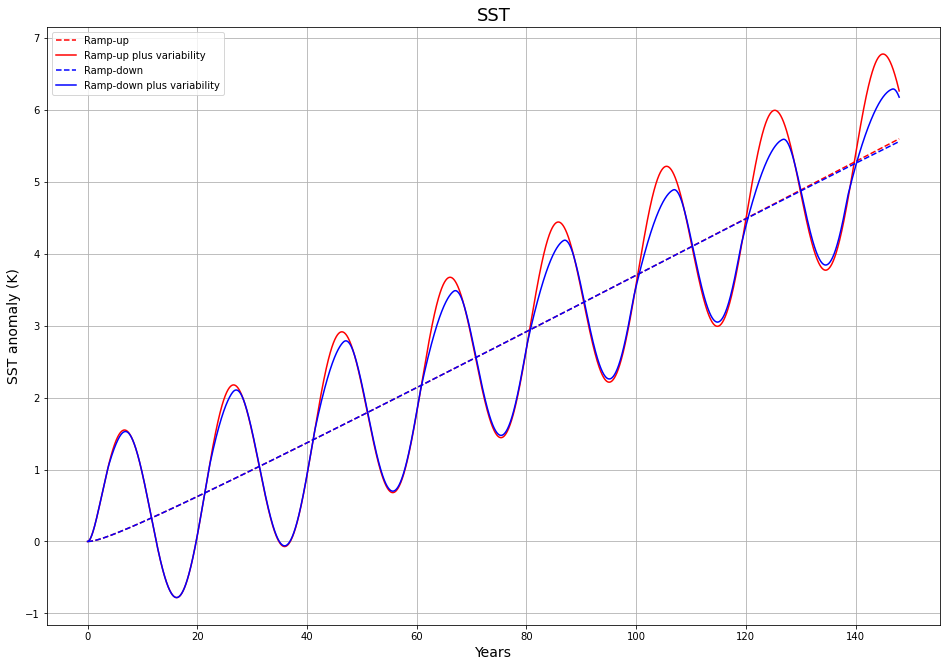

In [17]:
days = dt / 86400
timesteps = rampup.shape[1]
length = (timesteps - 1) * days/365 
time_years = np.linspace(0,length,timesteps)

# Ocean heat content over time

#Calculate ocean heat content
OHC_control = OHC(control_expt)
OHC_rampup = OHC(rampup)
OHC_rampup_vari = OHC(rampup_vari)
OHC_rampdown = OHC(rampdown)
OHC_rampdown_vari = OHC(rampdown_vari)

#Plot
plt.figure(figsize=(16,11))
plt.plot(time_years, OHC_rampup - OHC_control, color='r', linestyle='--', label='Ramp-up')
plt.plot(time_years, OHC_rampup_vari - OHC_control, color='r', label='Ramp-up plus variability')
plt.plot(time_years, - 1 * (OHC_rampdown - OHC_control), color='b', linestyle='--', label='Ramp-down')
plt.plot(time_years, -1 * (OHC_rampdown_vari - OHC_control), color='b', label='Ramp-down plus variability')


plt.grid()
plt.title('OHC', fontsize = 18)
plt.ylabel('OHC anomaly (J m$^{-2}$)', fontsize = 14)
plt.xlabel('Years', fontsize = 14)
plt.legend(fontsize=14)
#plt.savefig('OHC, kappa = {}, Q = {}.jpg'.format(kappa, Q))

# # SST over time
plt.figure(figsize=(16,11))
plt.plot(time_years, rampup[0, :] - control_expt[0, :], color='r', linestyle='--', label='Ramp-up')
plt.plot(time_years, rampup_vari[0, :] - control_expt[0, :], color='r', label='Ramp-up plus variability')
plt.plot(time_years, -1 * (rampdown[0, :] - control_expt[0, :]), color='b', linestyle='--', label='Ramp-down')
plt.plot(time_years, -1 * (rampdown_vari[0, :] - control_expt[0, :]), color='b', label='Ramp-down plus variability')

plt.grid()
plt.title('SST', fontsize = 18)
plt.ylabel('SST anomaly (K)', fontsize = 14)
plt.xlabel('Years',fontsize = 14)
plt.legend()
#plt.savefig('SST and GAT anomalies, single abrupt, kappa = {}, Q = {}, gamma = {}.jpg'.format(kappa, Q, gamma_year))

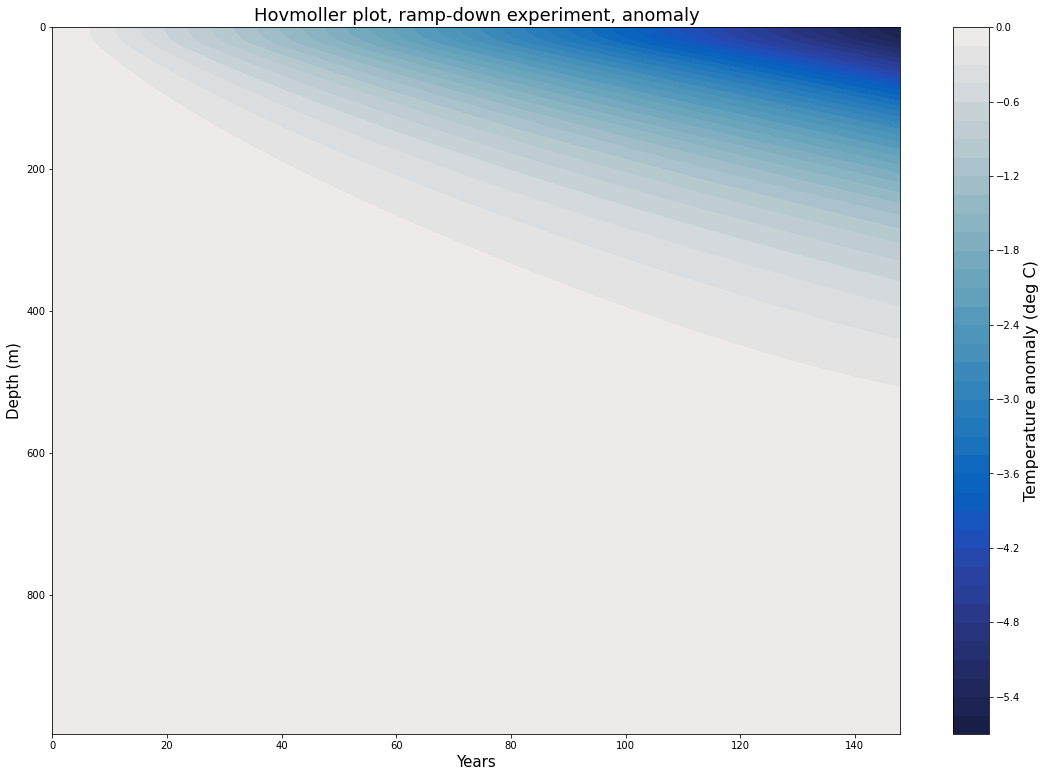

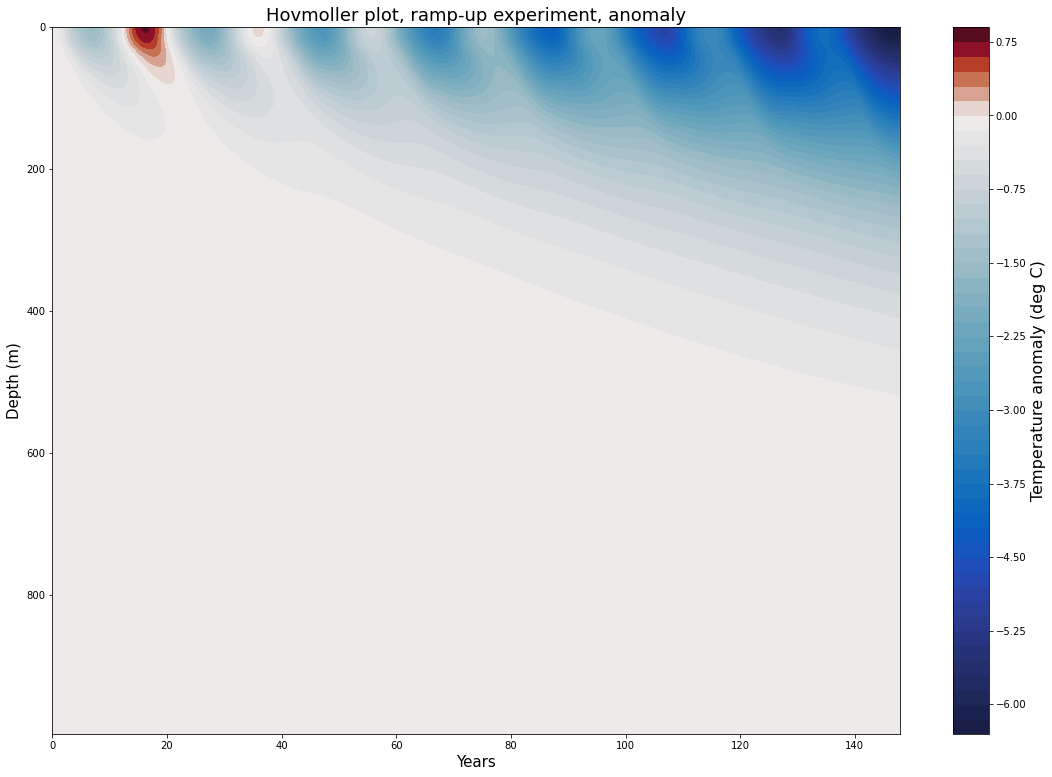

In [18]:
### Hovmoller plot

tt, zz = np.meshgrid(time_years, z[:-1])
rampup_anom = rampup - control_expt
rampup_vari_anom = rampup_vari - control_expt
rampdown_anom = rampdown - control_expt
rampdown_vari_anom = rampdown_vari - control_expt

cmap = cm.cm.balance
Tmin = np.min(rampdown_anom)
Tmax = np.max(rampdown_anom)

plt.figure(figsize=(19,13))
plt.contourf(tt, zz, rampdown_anom, levels=51, cmap=cmap, norm=TwoSlopeNorm(0))
plt.colorbar().set_label(label='Temperature anomaly (deg C)', size=16)
plt.title('Hovmoller plot, ramp-down experiment, anomaly', fontsize = 18)
plt.xlabel('Years', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.gca().invert_yaxis()

plt.figure(figsize=(19,13))
plt.contourf(tt, zz, rampdown_vari_anom, levels=51, cmap=cmap, norm=TwoSlopeNorm(0))
plt.colorbar().set_label(label='Temperature anomaly (deg C)', size=16)
plt.title('Hovmoller plot, ramp-up experiment, anomaly', fontsize = 18)
plt.xlabel('Years', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.gca().invert_yaxis()

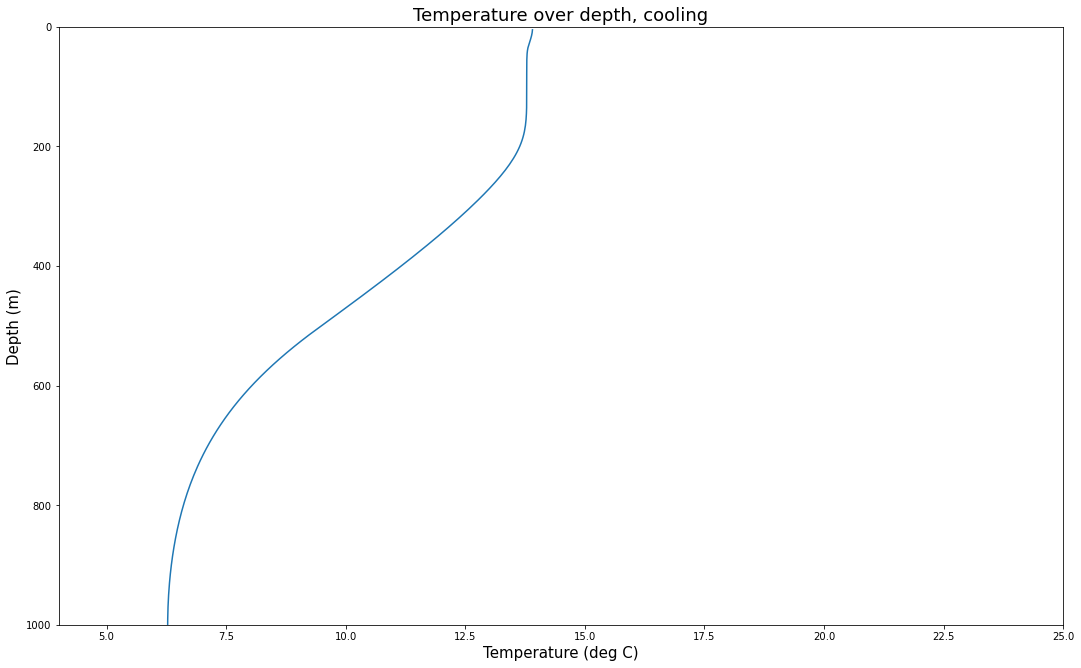

In [48]:
#Animate the forcing

expt = rampdown_vari

fig = plt.figure(figsize=(18,11))
ax = plt.axes(xlim=(4, 25), ylim=(z[0], z[-1]))

line, = plt.plot([], [])

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(expt[:, i], z[1 : ])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(expt[0, :]), interval=50, blit=True)

title = 'Temperature over depth, cooling'

ax.set_title(title, fontsize = 18)
ax.set_xlabel('Temperature (deg C)', fontsize = 15)
ax.set_ylabel('Depth (m)', fontsize = 15)
ax.invert_yaxis()

#anim.save('Ramp-down + variability.mp4')
#plt.show()